#### 1. Model performance chart

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import json
with open("history.json", "r") as f:
    data = json.loads(f.read())
    epoch_train, loss = [x['epoch'] for x in data['train']], [x['loss'] for x in data['train']]
    epoch_val, precision = [x['epoch'] for x in data['val']], [x['accuracy'] for x in data['val']]
    
    print(f"Maximum Acc : {max(precision)}")
    print(f"Lowest Loss : {min(loss)}")

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,5))

ax[0].plot(epoch_train, loss, 'r')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Train Loss')

ax[1].plot(epoch_val, precision, 'b')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Val Precision')

fig.tight_layout()
plt.show()

#### 2. Model predictions

In [2]:
import os
import glob
import time
import random
import torch
import cv2 
import numpy as np
from PIL import Image
from model.AlexNet import AlexNet
from utils.dataset import build_dataloader
from utils.common import get_all_embeddings
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 200
EMBEDDING_SIZE = 64

VAL_DATASET = "./dataset/valid"
TEST_DATASET = "./dataset/test"
MODEL_PATH = "./weights/model_best.pth"

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Normalize(MEAN, STD),
])

# Val Dataloader
val_dataset, val_loader = build_dataloader(
    batch_size=BATCH_SIZE,
    root_dir=VAL_DATASET,
    transform=transform,
    shuffle=False
)

# Test Dataloader
test_dataset, test_loader = build_dataloader(
    batch_size=BATCH_SIZE,
    root_dir=TEST_DATASET,
    transform=transform,
    shuffle=False
)

In [ ]:
DEVICE = torch.device("cuda:0")
model = AlexNet(input_size=IMAGE_SIZE, embedding_size=EMBEDDING_SIZE).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# For all the images in test set, find most similar image in val set
with torch.no_grad():
    # This is a faster way
    val_embeddings, val_labels = get_all_embeddings(val_dataset, model, device=DEVICE)
    test_embeddings, test_labels = get_all_embeddings(test_dataset, model, device=DEVICE)
    dist = torch.cdist(test_embeddings, val_embeddings)

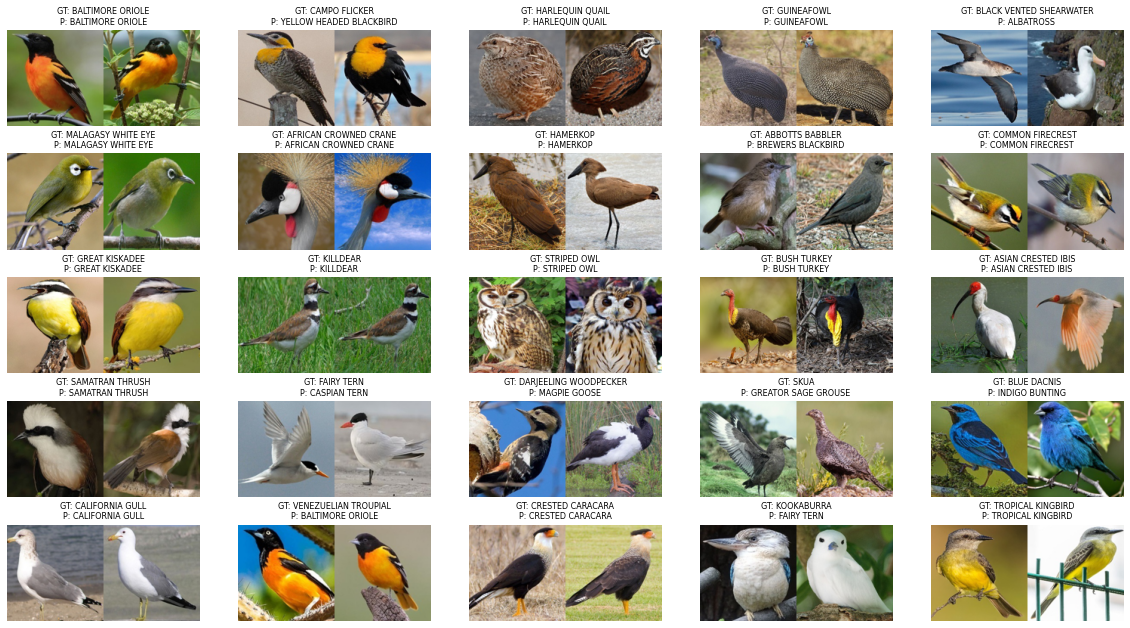

In [6]:
plt.figure(figsize = (20,11))
for i, idx in enumerate(np.random.choice(len(test_dataset), size=25, replace=False)):
    matched_idx = dist[idx].argmin().item()
    
    actual_label = test_dataset.labels[idx]
    predicted_label = val_dataset.labels[matched_idx]
    
    actual_image_path = test_dataset.images[idx]
    predicted_image_path = val_dataset.images[matched_idx]
    
    actual_image = np.array(Image.open(actual_image_path).resize((IMAGE_SIZE, IMAGE_SIZE)))
    predicted_image = np.array(Image.open(predicted_image_path).resize((IMAGE_SIZE, IMAGE_SIZE)))
    stack = np.hstack([actual_image, predicted_image])
    
    plt.subplot(5, 5, i+1)
    plt.imshow(stack)
    plt.title(f"GT: {actual_label}\nP: {predicted_label}", fontdict = {'fontsize' : 8})
    plt.axis("off")

In [ ]:
# Alternative way to find matches without
# It doesn't requires test images to have labels

# BATCH_SIZE = 200
# embeddings = {}

# # index all val images
# with torch.no_grad():
#     for start_idx in range(0, len(VAL_IMAGES), BATCH_SIZE):
#         images = torch.empty(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
#         for i in range(BATCH_SIZE):
#             if start_idx+i == len(VAL_IMAGES):
#                 break
            
#             # Create batch of images
#             path = VAL_IMAGES[start_idx+i]
#             images[i] = transform(Image.open(path))
        
#         for i, embedding in enumerate(model(images.to(DEVICE))):
#             # process batch of images in a single forward pass
#             embeddings[start_idx+i] = embedding.cpu().numpy()


# query_images = np.array(glob.glob("./dataset/test/*/*"))

# # choose n random images to test
# paths = query_images[np.random.choice(len(query_images), size=25, replace=False)]

# plt.figure(figsize = (20,11))
# for i, query_image in enumerate(paths):
#     actual_label = os.path.basename(os.path.dirname(query_image))
#     query_image = Image.open(query_image).resize((IMAGE_SIZE, IMAGE_SIZE))
#     query_tensor = transform(query_image).to(DEVICE)
#     query_image = np.array(query_image)
    
#     with torch.no_grad():
#         query_embedding = model(query_tensor.unsqueeze(0)).flatten().cpu().numpy()

#     results = []
#     for (idx, embedding) in embeddings.items():
#         dist = cosine_distance(query_embedding, embedding)
#         results.append((idx, dist))

#     results.sort(key=lambda x:x[1])

#     K = 1 # show top k matches
#     for (idx, dist) in results[:K]:
#         predicted_label = os.path.basename(os.path.dirname(VAL_IMAGES[idx]))
#         predicted_image = np.array(Image.open(VAL_IMAGES[idx]).resize((IMAGE_SIZE, IMAGE_SIZE)))
#         stack = np.hstack([query_image, predicted_image])
 
#     plt.subplot(5, 5, i+1)
#     plt.imshow(stack)    
#     plt.title(f"GT: {actual_label}\nP: {predicted_label}", fontdict = {'fontsize' : 8})
#     plt.axis("off")